In [3]:
import numpy as np
import os
import librosa
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential 
from keras.layers import  Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
#l=['silence','unknown']
file_path="audio"
max_pad_length=40
random_state=42

Using TensorFlow backend.


In [4]:
def test_wavfile(path="audio/go/0d53e045_nohash_1.wav"):
    
    sample_rate, samples = wavfile.read(path)
    frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
    plt.pcolormesh(times, frequencies, spectrogram)
    plt.imshow(spectrogram)
    plt.ylabel('Frequecy [HZ]')
    plt.xlabel('Time [sec]')
    plt.show()

In [5]:
def convert_wave_to_mfcc(filePath):
    wav, sr =librosa.load(filePath, mono = True, sr=None)
    mfcc = librosa.feature.mfcc(wav, sr=sr)
    ##padding
    mfcc_feature = np.pad(mfcc, pad_width=((0, 0), (0, max_pad_length - mfcc.shape[1])), mode='constant')
    return mfcc_feature

In [6]:
def get_labels(path=file_path):
    return os.listdir(path)

In [7]:
def save_mfcc_files(path=file_path):
    labels = get_labels(path)
    #print(labels)
    for label in labels:
        mfcc_features=[]
        audfiles=[path+'/'+label+'/'+aud for aud in os.listdir(path+'/'+label)]
        for audio in audfiles:
            mfcc_features.append(convert_wave_to_mfcc(audio))
        #print(len(mfcc_vectors))
        np.save(label+'.npy', mfcc_features)

In [8]:
get_labels()
#print(len(get_labels()))
#save_mfcc_files()

['stop',
 'left',
 'unknown',
 'off',
 'yes',
 'up',
 'on',
 'down',
 'no',
 'go',
 'right',
 'silence']

In [9]:
def generate_training_testing_set(path=file_path,test_size=.3):
    labels = get_labels(path)
    #features=[]
    features=np.load(labels[0]+'.npy')
    classes=np.zeros(features.shape[0])
    #for i,label in zip(range(0,len(labels)-1),labels):
    for i in range(1,len(labels)):
        x=np.load(labels[i]+'.npy')
        features=np.vstack((features,x))
        classes=np.append(classes, np.full(x.shape[0], fill_value= (i)))
    return train_test_split(features, classes, test_size= test_size, random_state=random_state, shuffle=True)

In [10]:
def generate_training_testing_set1(path=file_path,test_size=.3):
    labels=get_labels(path)
    features=np.load(labels[0]+'.npy')
    classes=np.zeros(features.shape[0])
    print(classes[1])
    feature_train, feature_test, labels_train, labels_test = train_test_split(features, classes,
                                        test_size= test_size, random_state=random_state, shuffle=True)
    for i in range(1,len(labels)):
        x=np.load(labels[i]+'.npy')
        #features=np.vstack((features,x))
        y= np.full(x.shape[0], fill_value= (i))
        #print(labels[i])
        X_train, X_test, y_train, y_test=train_test_split(x, y,
                                    test_size= test_size, random_state=random_state, shuffle=True)
     
        
        feature_train=np.vstack((feature_train,X_train))
        feature_test=np.vstack((feature_test,X_test))
       
        labels_train=np.append(labels_train,y_train)
        labels_test=np.append(labels_test,y_test)
        
    return feature_train, feature_test, labels_train, labels_test

In [20]:
X_train, X_test, y_train, y_test = generate_training_testing_set()

model =Sequential()
model.add(Conv2D(32,kernel_size=(2,2),activation='relu',input_shape=(20,40,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))
model.add(Conv2D(64,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.2))
model.add(Conv2D(128,kernel_size=(2,2),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(.25))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(.2))
model.add(Dense(12,activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizers.adadelta(),
              metrics=['accuracy'])


In [2]:
print ( len(X_train), len(y_train))

NameError: name 'X_train' is not defined

In [23]:
checkpointer = ModelCheckpoint(filepath='weights.hdf5',verbose=1,save_best_only=True)
history=model.fit(X_train.reshape(X_train.shape[0],20,40,1), to_categorical(y_train),
          batch_size=256, epochs=400, verbose=1,validation_split=0.3,callbacks=[checkpointer] )

Train on 13776 samples, validate on 5904 samples
Epoch 1/400
13776/13776 [==============================] - 1s 108us/step - loss: 0.9061 - acc: 0.6900 - val_loss: 0.6272 - val_acc: 0.7988
Epoch 2/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.8784 - acc: 0.6983 - val_loss: 0.6088 - val_acc: 0.8045
Epoch 3/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.8501 - acc: 0.7093 - val_loss: 0.5876 - val_acc: 0.8091
Epoch 4/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.8208 - acc: 0.7224 - val_loss: 0.5742 - val_acc: 0.8093
Epoch 5/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.8245 - acc: 0.7178 - val_loss: 0.5705 - val_acc: 0.8161
Epoch 6/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.7920 - acc: 0.7258 - val_loss: 0.5421 - val_acc: 0.8293
Epoch 7/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.7811 - acc: 0.7306 - val_loss: 0.5395

13776/13776 [==============================] - 1s 98us/step - loss: 0.4230 - acc: 0.8577 - val_loss: 0.3283 - val_acc: 0.8948
Epoch 57/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.4279 - acc: 0.8534 - val_loss: 0.3200 - val_acc: 0.8987
Epoch 58/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.4288 - acc: 0.8542 - val_loss: 0.3289 - val_acc: 0.8985
Epoch 59/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.4204 - acc: 0.8583 - val_loss: 0.3208 - val_acc: 0.8994
Epoch 60/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.4110 - acc: 0.8595 - val_loss: 0.3199 - val_acc: 0.8963
Epoch 61/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.4156 - acc: 0.8577 - val_loss: 0.3174 - val_acc: 0.9006
Epoch 62/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.4047 - acc: 0.8640 - val_loss: 0.3141 - val_acc: 0.8982
Epoch 63/400
13776/13776 [============

Epoch 86/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.3614 - acc: 0.8778 - val_loss: 0.2952 - val_acc: 0.9065
Epoch 87/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.3459 - acc: 0.8846 - val_loss: 0.2873 - val_acc: 0.9101
Epoch 88/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.3516 - acc: 0.8825 - val_loss: 0.2887 - val_acc: 0.9084
Epoch 89/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.3454 - acc: 0.8838 - val_loss: 0.2911 - val_acc: 0.9084
Epoch 90/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.3485 - acc: 0.8809 - val_loss: 0.2909 - val_acc: 0.9099
Epoch 91/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.3417 - acc: 0.8800 - val_loss: 0.2931 - val_acc: 0.9074
Epoch 92/400
13776/13776 [==============================] - 1s 100us/step - loss: 0.3421 - acc: 0.8842 - val_loss: 0.2868 - val_acc: 0.9092
Epoch 93/400
13776/13776 

Epoch 116/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.3061 - acc: 0.8943 - val_loss: 0.2866 - val_acc: 0.9124
Epoch 117/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2983 - acc: 0.8966 - val_loss: 0.2822 - val_acc: 0.9138
Epoch 118/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.3044 - acc: 0.8970 - val_loss: 0.2750 - val_acc: 0.9138
Epoch 119/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.3009 - acc: 0.8985 - val_loss: 0.2749 - val_acc: 0.9140
Epoch 120/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2911 - acc: 0.9008 - val_loss: 0.2813 - val_acc: 0.9157
Epoch 121/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2936 - acc: 0.8997 - val_loss: 0.2770 - val_acc: 0.9148
Epoch 122/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2948 - acc: 0.8992 - val_loss: 0.2786 - val_acc: 0.9131
Epoch 123/400
13776/

Epoch 147/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2701 - acc: 0.9058 - val_loss: 0.2708 - val_acc: 0.9175
Epoch 148/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2615 - acc: 0.9113 - val_loss: 0.2740 - val_acc: 0.9153
Epoch 149/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2592 - acc: 0.9120 - val_loss: 0.2747 - val_acc: 0.9158
Epoch 150/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2547 - acc: 0.9130 - val_loss: 0.2708 - val_acc: 0.9131
Epoch 151/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2583 - acc: 0.9127 - val_loss: 0.2709 - val_acc: 0.9148
Epoch 152/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2682 - acc: 0.9090 - val_loss: 0.2703 - val_acc: 0.9175
Epoch 153/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2637 - acc: 0.9104 - val_loss: 0.2705 - val_acc: 0.9173
Epoch 154/400
13776/

Epoch 178/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2331 - acc: 0.9227 - val_loss: 0.2665 - val_acc: 0.9197
Epoch 179/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2336 - acc: 0.9219 - val_loss: 0.2679 - val_acc: 0.9197
Epoch 180/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.2480 - acc: 0.9162 - val_loss: 0.2638 - val_acc: 0.9175
Epoch 181/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2432 - acc: 0.9171 - val_loss: 0.2616 - val_acc: 0.9173
Epoch 182/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2385 - acc: 0.9173 - val_loss: 0.2644 - val_acc: 0.9184
Epoch 183/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2337 - acc: 0.9194 - val_loss: 0.2692 - val_acc: 0.9182
Epoch 184/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2389 - acc: 0.9157 - val_loss: 0.2652 - val_acc: 0.9197
Epoch 185/400
13776/

Epoch 209/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2293 - acc: 0.9206 - val_loss: 0.2638 - val_acc: 0.9207
Epoch 210/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2188 - acc: 0.9260 - val_loss: 0.2637 - val_acc: 0.9202
Epoch 211/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2102 - acc: 0.9276 - val_loss: 0.2628 - val_acc: 0.9179
Epoch 212/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2201 - acc: 0.9267 - val_loss: 0.2633 - val_acc: 0.9202
Epoch 213/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2310 - acc: 0.9225 - val_loss: 0.2657 - val_acc: 0.9179
Epoch 214/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2230 - acc: 0.9261 - val_loss: 0.2680 - val_acc: 0.9182
Epoch 215/400
13776/13776 [==============================] - 1s 99us/step - loss: 0.2248 - acc: 0.9236 - val_loss: 0.2574 - val_acc: 0.9228
Epoch 216/400
13776/

Epoch 240/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.2077 - acc: 0.9289 - val_loss: 0.2652 - val_acc: 0.9221
Epoch 241/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.2074 - acc: 0.9281 - val_loss: 0.2664 - val_acc: 0.9187
Epoch 242/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.2004 - acc: 0.9333 - val_loss: 0.2638 - val_acc: 0.9207
Epoch 243/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.1978 - acc: 0.9331 - val_loss: 0.2745 - val_acc: 0.9187
Epoch 244/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1979 - acc: 0.9326 - val_loss: 0.2690 - val_acc: 0.9187
Epoch 245/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2010 - acc: 0.9321 - val_loss: 0.2635 - val_acc: 0.9189
Epoch 246/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.2068 - acc: 0.9282 - val_loss: 0.2633 - val_acc: 0.9189
Epoch 247/400
13776/

Epoch 272/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1987 - acc: 0.9326 - val_loss: 0.2662 - val_acc: 0.9180
Epoch 273/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.2018 - acc: 0.9324 - val_loss: 0.2734 - val_acc: 0.9165
Epoch 274/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1910 - acc: 0.9376 - val_loss: 0.2642 - val_acc: 0.9194
Epoch 275/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1799 - acc: 0.9358 - val_loss: 0.2664 - val_acc: 0.9207
Epoch 276/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1902 - acc: 0.9337 - val_loss: 0.2608 - val_acc: 0.9212
Epoch 277/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1927 - acc: 0.9347 - val_loss: 0.2670 - val_acc: 0.9245
Epoch 278/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1849 - acc: 0.9391 - val_loss: 0.2702 - val_acc: 0.9204
Epoch 279/400
13776/

Epoch 335/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.1704 - acc: 0.9413 - val_loss: 0.2670 - val_acc: 0.9202
Epoch 336/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1741 - acc: 0.9390 - val_loss: 0.2646 - val_acc: 0.9221
Epoch 337/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1704 - acc: 0.9421 - val_loss: 0.2667 - val_acc: 0.9229
Epoch 338/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1662 - acc: 0.9447 - val_loss: 0.2702 - val_acc: 0.9223
Epoch 339/400
13776/13776 [==============================] - 1s 97us/step - loss: 0.1789 - acc: 0.9393 - val_loss: 0.2748 - val_acc: 0.9189
Epoch 340/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1706 - acc: 0.9424 - val_loss: 0.2705 - val_acc: 0.9219
Epoch 341/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1609 - acc: 0.9448 - val_loss: 0.2672 - val_acc: 0.9217
Epoch 342/400
13776/

Epoch 367/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1626 - acc: 0.9450 - val_loss: 0.2760 - val_acc: 0.9192
Epoch 368/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1623 - acc: 0.9452 - val_loss: 0.2688 - val_acc: 0.9207
Epoch 369/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1649 - acc: 0.9462 - val_loss: 0.2790 - val_acc: 0.9204
Epoch 370/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1664 - acc: 0.9422 - val_loss: 0.2644 - val_acc: 0.9201
Epoch 371/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1638 - acc: 0.9424 - val_loss: 0.2709 - val_acc: 0.9221
Epoch 372/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1584 - acc: 0.9443 - val_loss: 0.2759 - val_acc: 0.9214
Epoch 373/400
13776/13776 [==============================] - 1s 98us/step - loss: 0.1631 - acc: 0.9442 - val_loss: 0.2677 - val_acc: 0.9224
Epoch 374/400
13776/

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


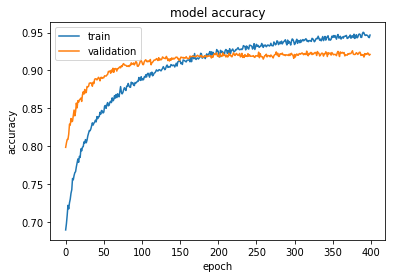

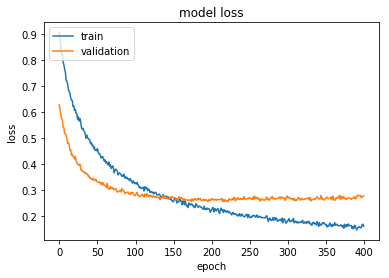

In [24]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [25]:
model.load_weights('weights.hdf5')

In [26]:
y_predictions = [np.argmax(model.predict(np.expand_dims(example,axis=0))) for example in X_test.reshape(X_test.shape[0],20,40,1)]

accuracy =100*np.sum(np.array(y_predictions)==np.argmax( to_categorical(y_test),axis=1))/len(y_predictions)

print ('test accurac : %.4f%%' % accuracy)

test accurac : 91.9621%


In [1]:
def test (path):
    #path=r"C:\Users\abdal_000\Downloads\data-set\test\audio\clip_0a77ea19a.wav"
    mfcc_feature=convert_wave_to_mfcc(path)
    #print(mfcc_feature.shape)
    
    pre=model.predict(mfcc_feature.reshape(1,20,40,1))
    return np.argmax(pre)

In [ ]:
import csv
audfiles=os.listdir(r"C:\Users\abdal_000\Downloads\data-set\test\audio")
print (audfiles[0])
with open('sample_submission.csv', 'w', newline='') as csvfile:
    fieldnames=['fname','label']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    for audio in audfiles:
        pred = test(r"C:\Users\abdal_000\Downloads\data-set\test\audio\\"+audio)
        writer.writerow({'fname':audio,'label':labels[pred]})
    